Number of Clusters: 5
Davies-Bouldin Index: 1.2564758693634592
Silhouette Score: 0.27197135755094076


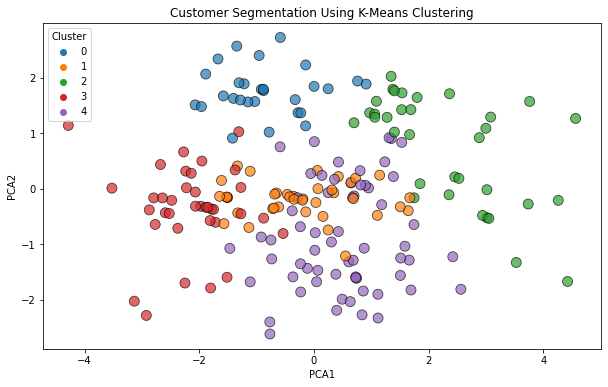

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# 2. Data Preprocessing

# Merge transactions with customer data
merged_data = pd.merge(transactions, customers[['CustomerID', 'Region']], on='CustomerID', how='left')

# Aggregating transaction features per customer (total spent, number of transactions, etc.)
customer_transactions = merged_data.groupby('CustomerID').agg(
    total_spent=pd.NamedAgg(column='TotalValue', aggfunc='sum'),
    num_transactions=pd.NamedAgg(column='TransactionID', aggfunc='nunique'),
    avg_spent_per_transaction=pd.NamedAgg(column='TotalValue', aggfunc='mean'),
    max_spent_per_transaction=pd.NamedAgg(column='TotalValue', aggfunc='max')
).reset_index()

# 3. Feature Engineering

# Combine customer transaction features with region info (one-hot encoding for Region)
customer_data = pd.merge(customer_transactions, customers[['CustomerID', 'Region']], on='CustomerID', how='left')

# One-hot encode the 'Region' feature to avoid categorical issues in clustering
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# 4. Feature Scaling (Standardize the features)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data.drop('CustomerID', axis=1))

# 5. Clustering (Using K-Means)

# Set number of clusters (between 2 and 10)
n_clusters = 5

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

# 6. Evaluation

# Calculate Davies-Bouldin index (lower is better)
db_index = davies_bouldin_score(scaled_features, customer_data['Cluster'])

# Calculate silhouette score (higher is better)
sil_score = silhouette_score(scaled_features, customer_data['Cluster'])

# Output clustering metrics
print(f"Number of Clusters: {n_clusters}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {sil_score}")

# 7. Visualization

# Reduce to 2D for visualization using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = customer_data['Cluster']

# Plot the clusters in 2D space
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100, alpha=0.7, edgecolor='k')
plt.title('Customer Segmentation Using K-Means Clustering')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

# Save the result with cluster labels
customer_data[['CustomerID', 'Cluster']].to_csv('Customer_Segmentation_Results.csv', index=False)
